In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import exp
import os, time

In [2]:
def getFilesFrom(baseDir):
    files = []
    
    for file in os.listdir(baseDir):
        if '.csv' not in file:
            continue

        filePath = os.path.join(baseDir, file) if baseDir else file
        files.append(filePath)

    return files


files = getFilesFrom('files')
files

['files\\test_1.csv',
 'files\\test_10.csv',
 'files\\test_11.csv',
 'files\\test_12.csv',
 'files\\test_2.csv',
 'files\\test_3.csv',
 'files\\test_4.csv',
 'files\\test_5.csv',
 'files\\test_6.csv',
 'files\\test_7.csv',
 'files\\test_8.csv',
 'files\\test_9.csv']

In [24]:
df = pd.read_csv('DataBase.csv')
print('size:', len(df))
df

size: 11343


,time,pressure,mean,ratio,start_blow,stop_blow,blowing
0,0.0,298.387793,298.412961,-0.02521,False,False,False
1,0.1,298.384728,298.410824,-0.02614,False,False,False
2,0.2,298.381913,298.408618,-0.02675,False,False,False
3,0.3,298.379377,298.406342,-0.02701,False,False,False
4,0.4,298.377211,298.404016,-0.02685,False,False,False
...,...,...,...,...,...,...,...
11338,1132.7,390.135030,389.972507,0.20534,False,False,False
11339,1132.8,390.141844,389.981688,0.20235,False,False,False
11340,1132.9,390.146760,389.994225,0.19272,False,False,False
11341,1133.0,390.149878,390.008844,0.17819,False,False,False


# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

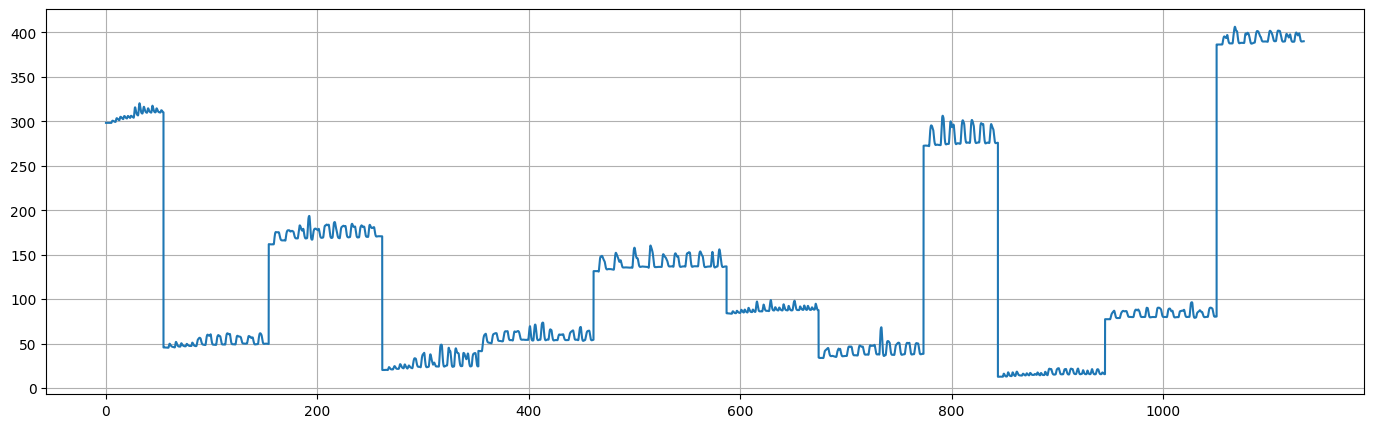

In [25]:
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.grid()

In [5]:
startCount = (df.start_blow == True).sum() / len(df) * 100
stopCount  = (df.stop_blow == True).sum()  / len(df)  * 100
total = int((startCount + stopCount) * len(df) / 100)

print(f'{startCount:.2f}% dos dados inicio de sopro')
print(f'{stopCount:.2f}% dos dados término de sopro')
print(f'total: {startCount + stopCount:.2f}% ({total} dados)')

13.87% dos dados inicio de sopro
25.72% dos dados término de sopro
total: 39.58% (4489 dados)


In [6]:
target = df.loc[(df.start_blow == False) & (df.stop_blow == False)].sample(frac=0.35, random_state=42)
df = df.drop(target.index).reset_index(drop=True)

startCount = (df.start_blow == True).sum() / len(df) * 100
stopCount  = (df.stop_blow == True).sum()  / len(df)  * 100
total = int((startCount + stopCount) * len(df) / 100)

print(f'{startCount:.2f}% dos dados inicio de sopro')
print(f'{stopCount:.2f}% dos dados término de sopro')
print(f'total: {startCount + stopCount:.2f}% ({total} dados)')

17.59% dos dados inicio de sopro
32.61% dos dados término de sopro
total: 50.20% (4490 dados)


# SEPARAÇÃO DOS DADOS
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [21]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}n[0]'] = table[key]

    for i in range(1, n):
        table[f'{var}n[{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}n[0]'] + [f'{var}n[{i}]' for i in range(1, n)]
    return table[columns]


def getTrainData(df, size=5):
    states = getStates(df, 'ratio', 'Y', size)
    mean   = df[['mean']]
    return pd.concat([mean, states], axis=1)


size  = 30
xData = getTrainData(df, size)
xData.head(10)

,mean,Yn[0],Yn[1],Yn[2],Yn[3],Yn[4],Yn[5],Yn[6],Yn[7],Yn[8],...,Yn[20],Yn[21],Yn[22],Yn[23],Yn[24],Yn[25],Yn[26],Yn[27],Yn[28],Yn[29]
0,40.02052,0.06265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.02697,0.05566,0.06265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.03331,0.04726,0.05566,0.06265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.03917,0.03828,0.04726,0.05566,0.06265,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40.04423,0.02940,0.03828,0.04726,0.05566,0.06265,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,40.04835,0.02052,0.02940,0.03828,0.04726,0.05566,0.06265,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,40.05160,0.01122,0.02052,0.02940,0.03828,0.04726,0.05566,0.06265,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,40.05419,0.00115,0.01122,0.02052,0.02940,0.03828,0.04726,0.05566,0.06265,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,40.05634,-0.00950,0.00115,0.01122,0.02052,0.02940,0.03828,0.04726,0.05566,0.06265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,40.05816,-0.01970,-0.00950,0.00115,0.01122,0.02052,0.02940,0.03828,0.04726,0.05566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
is_blowing = False

def isBlowing(startBlow, stopBlow):
    global is_blowing

    if startBlow:
        is_blowing = True

    if stopBlow:
        is_blowing = False

    return is_blowing

# MODELO LOGISTIC REGRESSION
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import random

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [10]:
def getModel(xData, yData, trainSize=0.20):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=trainSize)
    #model = LogisticRegression(class_weight='balanced')
    model = LogisticRegression()
    model.fit(xTreino, yTreino)
    return model

def plotModel(yTest, yModel, yNames, title=''):
    confusionMatrix = confusion_matrix(yTest, yModel)
    score = accuracy_score(yTest, yModel)

    plt.figure(figsize=(10, 5))
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=yNames, yticklabels=yNames)
    plt.xlabel('Predicted Label'), plt.ylabel('True Label')
    plt.title(f'Precisão do Modelo: {title} {score*100:.2f}%')
    plt.show()

In [11]:
def getBestModel(df, timeout=5):
    global is_blowing
    bestModel  = {'start': None, 'stop': None, 'score': 0.00}
    startTime  = time.time()
    xData = getTrainData(df, size)
    
    while time.time() - startTime < timeout:
        trainSize = random.uniform(0.20, 0.52)
        startBlowModel = getModel(xData, df.start_blow, trainSize)
        stopBlowModel  = getModel(xData, df.stop_blow, trainSize)

        yStart = startBlowModel.predict(xData)
        yStop  = stopBlowModel.predict(xData)

        is_blowing = False
        yBlow = [isBlowing(start, stop) for start, stop in zip(yStart, yStop)] 
        score = accuracy_score(df.blowing, yBlow)

        if score > bestModel['score']:
            print(f'score update: {score*100:.2f}% | train size: {trainSize:.2f}')
            bestModel = {'start': startBlowModel, 'stop': stopBlowModel, 'score': score}
        
        if score == 1.0:
            break
        
    return bestModel


model = getBestModel(df, timeout=200)
startBlowModel = model['start']
stopBlowModel  = model['stop']

score update: 96.74% | train size: 0.48
score update: 96.80% | train size: 0.21
score update: 96.90% | train size: 0.22
score update: 96.91% | train size: 0.29
score update: 97.01% | train size: 0.38
score update: 97.05% | train size: 0.33
score update: 97.12% | train size: 0.41
score update: 97.13% | train size: 0.46
score update: 97.14% | train size: 0.25
score update: 97.27% | train size: 0.38


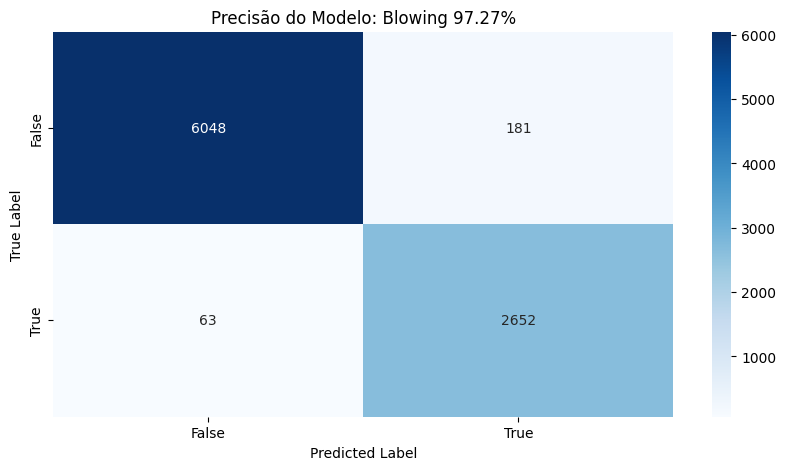

In [12]:
xData   = getTrainData(df, size)
classes = startBlowModel.classes_

df['start_blow_pred'] = startBlowModel.predict(xData)
df['stop_blow_pred']  = stopBlowModel.predict(xData)
df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
plotModel(df.prediction, df.blowing, classes, 'Blowing')

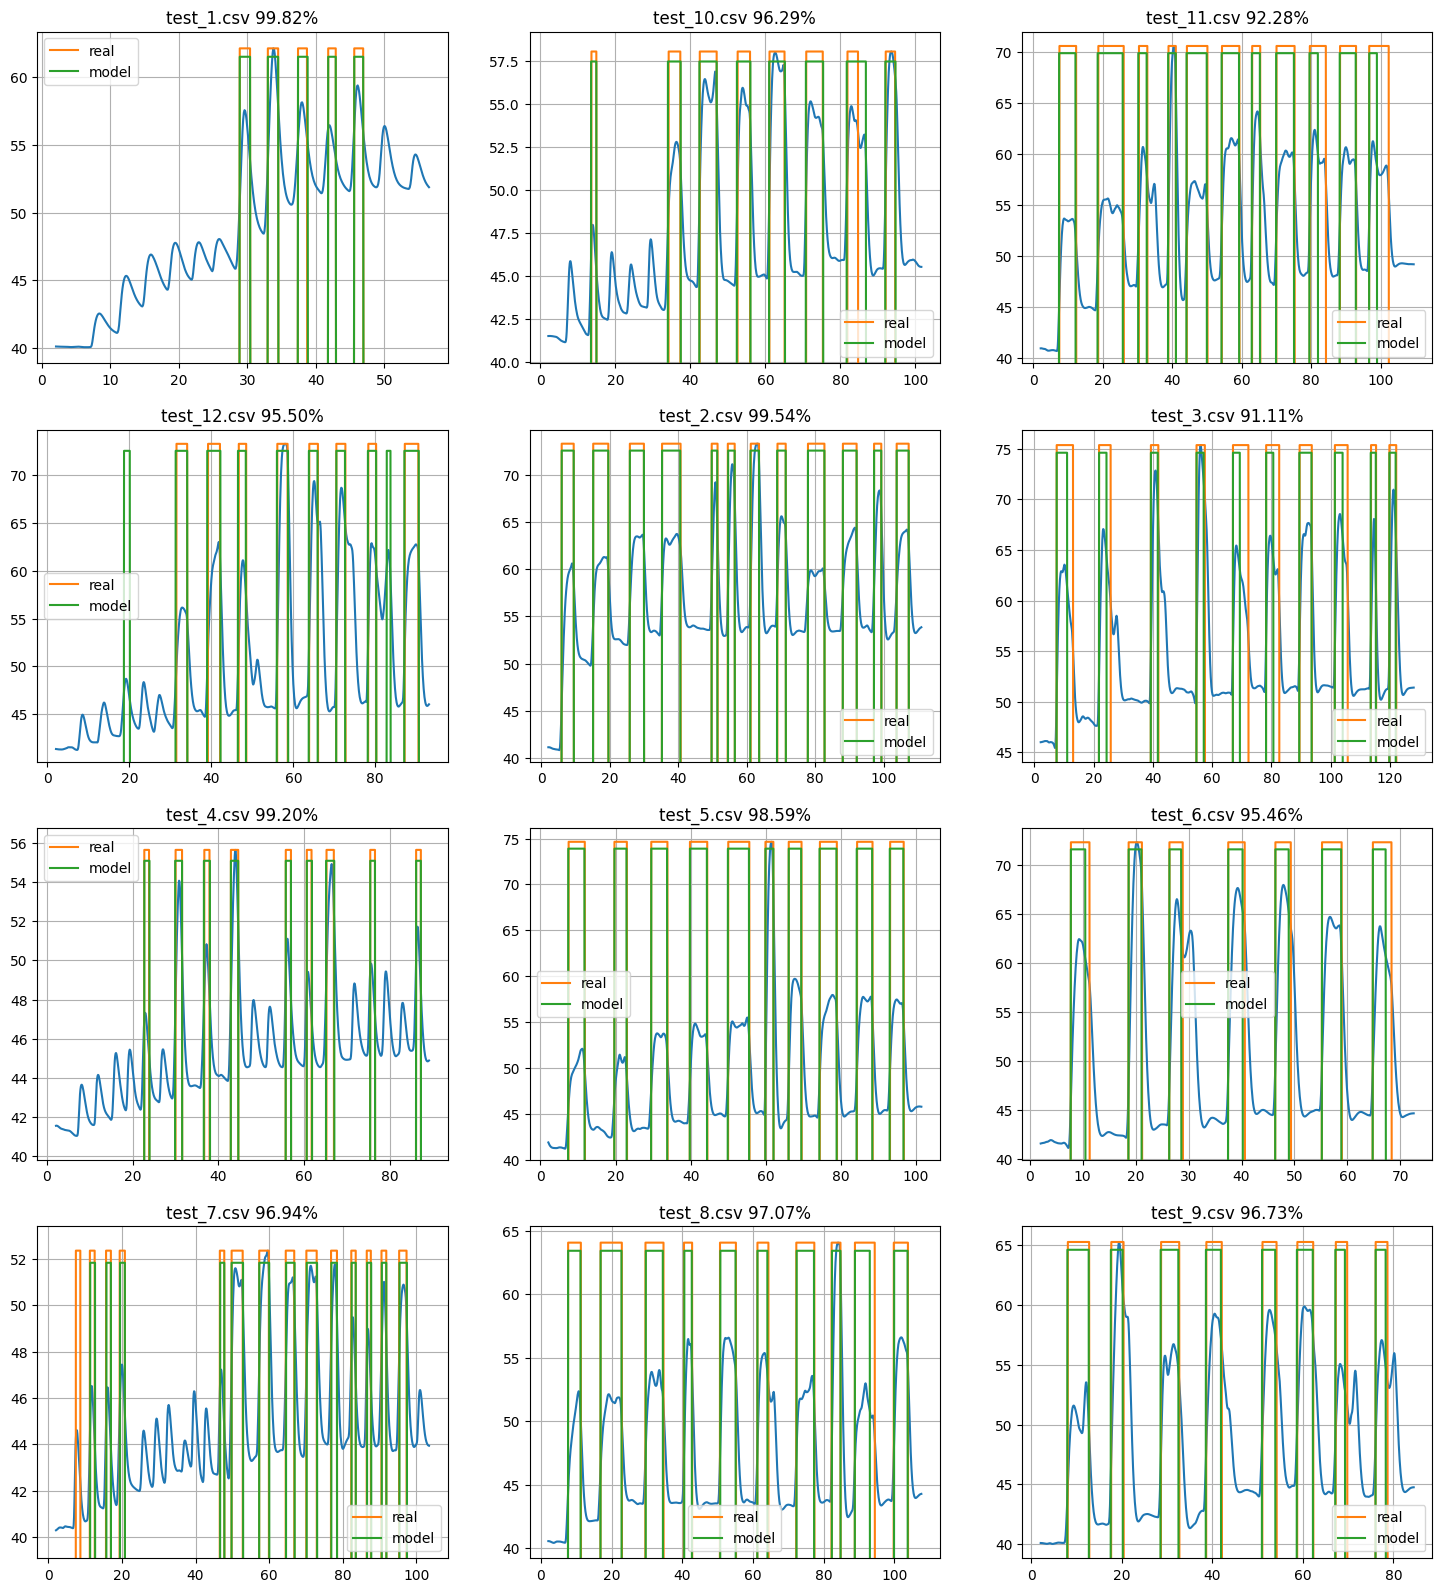

In [28]:
numRows = len(files) // 3 + 1
plt.figure(figsize=(18, 5*numRows))

for i, filePath in enumerate(files):
    df = pd.read_csv(filePath)
    xData = getTrainData(df, size)
    name  = filePath.split('\\')[-1]
    
    is_blowing = False
    df['start_blow_pred'] = startBlowModel.predict(xData)
    df['stop_blow_pred']  = stopBlowModel.predict(xData)
    df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
    score = accuracy_score(df.blowing, df.prediction)

    plt.subplot(numRows, 3, i+1)
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.prediction * 0.99 * max(df.pressure), label='model')
    plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
    plt.legend(), plt.grid(), plt.title(f'{name} {score*100:.2f}%')

# IMPLEMENTANDO O MODELO
Para implementar digitalmente em um arduino, o modelo LogisticRegression obedece a seguinte fórmula:
$$p = \frac{1}{1 + e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ....)}}$$

In [14]:
startBlowModel.feature_names_in_

array(['mean', 'Yn[0]', 'Yn[1]', 'Yn[2]', 'Yn[3]', 'Yn[4]', 'Yn[5]',
       'Yn[6]', 'Yn[7]', 'Yn[8]', 'Yn[9]', 'Yn[10]', 'Yn[11]', 'Yn[12]',
       'Yn[13]', 'Yn[14]', 'Yn[15]', 'Yn[16]', 'Yn[17]', 'Yn[18]',
       'Yn[19]', 'Yn[20]', 'Yn[21]', 'Yn[22]', 'Yn[23]', 'Yn[24]',
       'Yn[25]', 'Yn[26]', 'Yn[27]', 'Yn[28]', 'Yn[29]'], dtype=object)

In [15]:
startBlowModel.coef_[0]

array([-0.00402848,  2.82958149,  1.07260387,  0.17285376, -0.23196335,
       -0.36203798, -0.16432546, -0.05014186,  0.08788032,  0.14549003,
        0.24307283,  0.14093167,  0.11071144, -0.07326819, -0.24305012,
       -0.3475028 , -0.31379572,  0.17411852,  0.2268141 ,  0.14882388,
        0.12266532, -0.08278377,  0.03669462,  0.06751054, -0.0281608 ,
        0.01312914, -0.07185967,  0.01519931,  0.07684283,  0.07835058,
       -0.17263157])

In [16]:
def getModelString(model):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]
    variables = model.feature_names_in_
    
    text = f'(1.0 / (1.0 + exp(-({intercept:.6f}'

    for i, var in enumerate(variables):
        text += f' + {var}*({coefs[i]:6f})'
    
    return text + '))))'


startBlowModel

LogisticRegression()

In [17]:
startBlowString = getModelString(startBlowModel)
stopBlowString  = getModelString(stopBlowModel)

print(f'const float pBlow    = {startBlowString};')
print(f'const float pNotBlow = {stopBlowString};')
print()

const float pBlow    = (1.0 / (1.0 + exp(-(-11.826876 + mean*(-0.004028) + Yn[0]*(2.829581) + Yn[1]*(1.072604) + Yn[2]*(0.172854) + Yn[3]*(-0.231963) + Yn[4]*(-0.362038) + Yn[5]*(-0.164325) + Yn[6]*(-0.050142) + Yn[7]*(0.087880) + Yn[8]*(0.145490) + Yn[9]*(0.243073) + Yn[10]*(0.140932) + Yn[11]*(0.110711) + Yn[12]*(-0.073268) + Yn[13]*(-0.243050) + Yn[14]*(-0.347503) + Yn[15]*(-0.313796) + Yn[16]*(0.174119) + Yn[17]*(0.226814) + Yn[18]*(0.148824) + Yn[19]*(0.122665) + Yn[20]*(-0.082784) + Yn[21]*(0.036695) + Yn[22]*(0.067511) + Yn[23]*(-0.028161) + Yn[24]*(0.013129) + Yn[25]*(-0.071860) + Yn[26]*(0.015199) + Yn[27]*(0.076843) + Yn[28]*(0.078351) + Yn[29]*(-0.172632)))));
const float pNotBlow = (1.0 / (1.0 + exp(-(-3.279733 + mean*(-0.006689) + Yn[0]*(-2.372968) + Yn[1]*(-0.952373) + Yn[2]*(-0.105384) + Yn[3]*(0.276020) + Yn[4]*(0.213553) + Yn[5]*(0.197398) + Yn[6]*(-0.081377) + Yn[7]*(-0.098463) + Yn[8]*(-0.095841) + Yn[9]*(0.042839) + Yn[10]*(0.056504) + Yn[11]*(0.048467) + Yn[12]*(0.

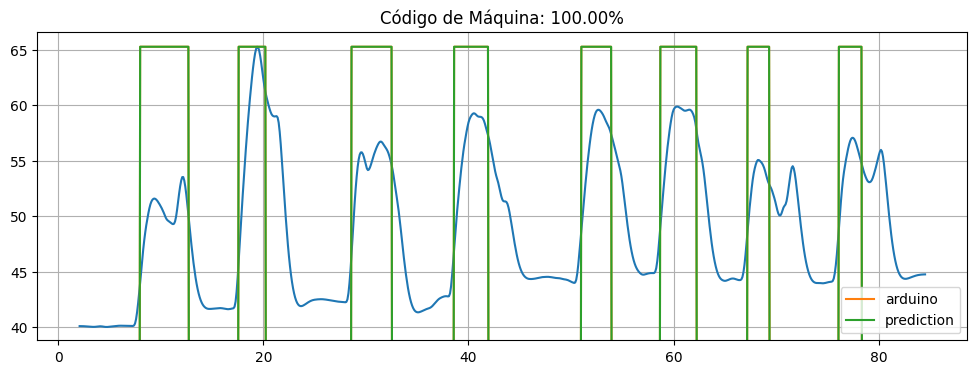

In [18]:
Yn = np.zeros(size)
is_blowing = False

def isBlowing(mean, ratio):
    global size, Yn, is_blowing

    for n in range(size-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Yn[0] = ratio
    pBlow    = eval(startBlowString)
    pNotBlow = eval(stopBlowString)

    if pBlow > 0.5:
        is_blowing = True
    
    if pNotBlow > 0.5:
        is_blowing = False

    return is_blowing


df['arduino'] = df.apply(lambda row: isBlowing(row['mean'], row['ratio']), axis=1)
score = accuracy_score(df.prediction, df.arduino)
plt.figure(figsize=(12, 4))
plt.title(f'Código de Máquina: {score*100:.2f}%')
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.arduino    * df.pressure.max(), label='arduino')
plt.plot(df.time, df.prediction * df.pressure.max(), label='prediction')
plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
plt.legend()
plt.grid()

files\test_1.csv


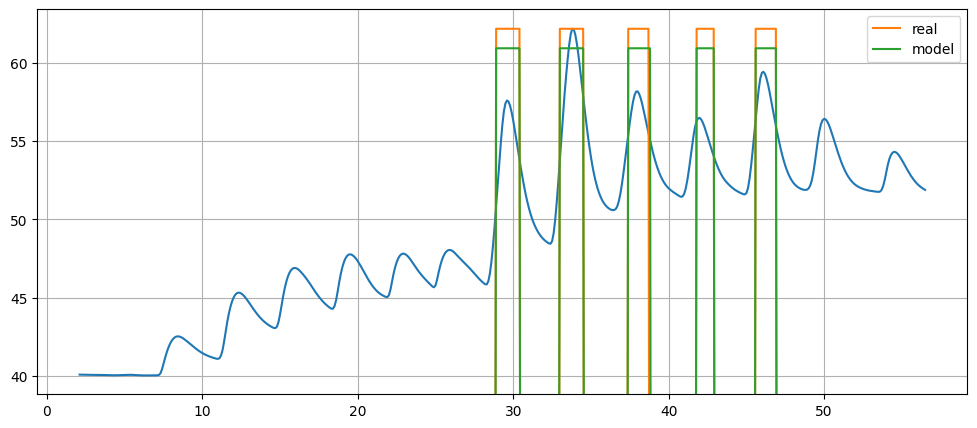

files\test_10.csv


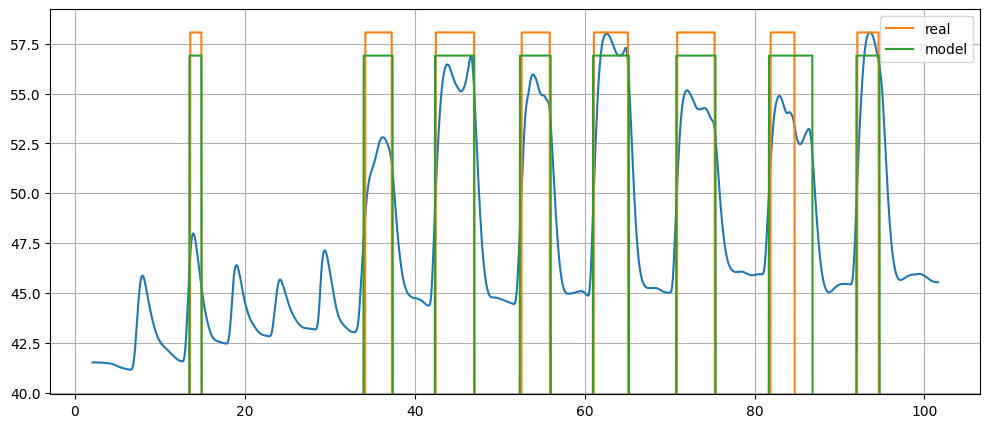

files\test_11.csv


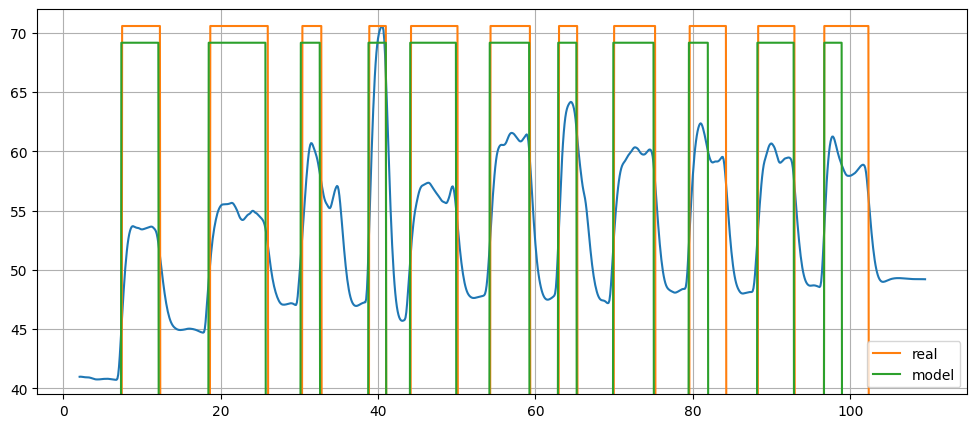

files\test_12.csv


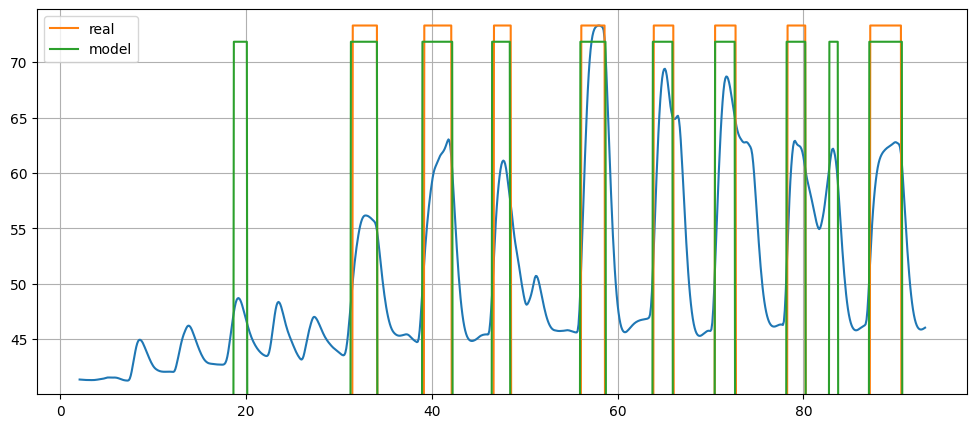

files\test_2.csv


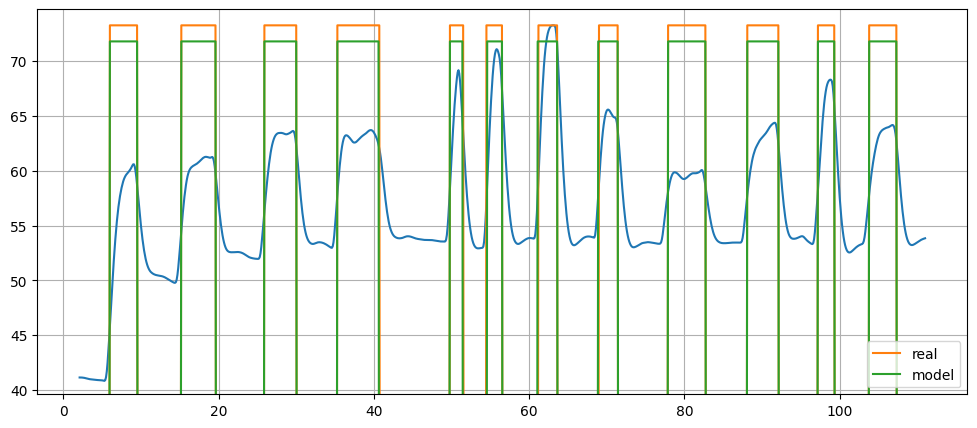

files\test_3.csv


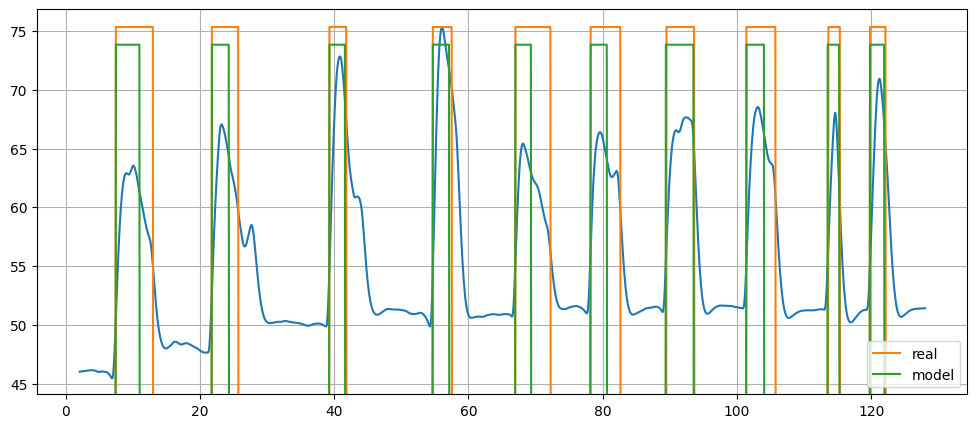

files\test_4.csv


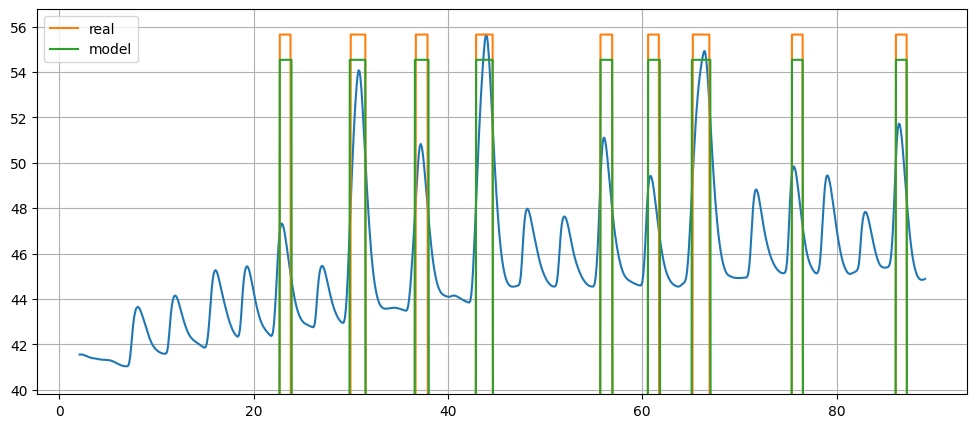

files\test_5.csv


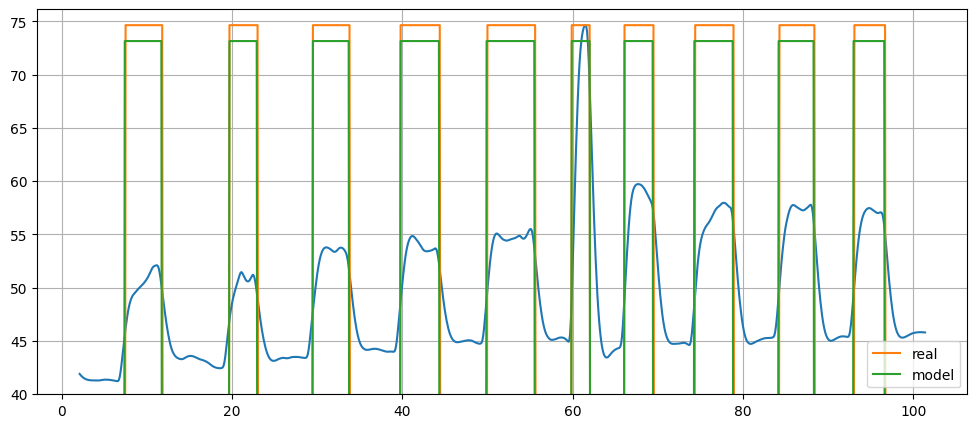

files\test_6.csv


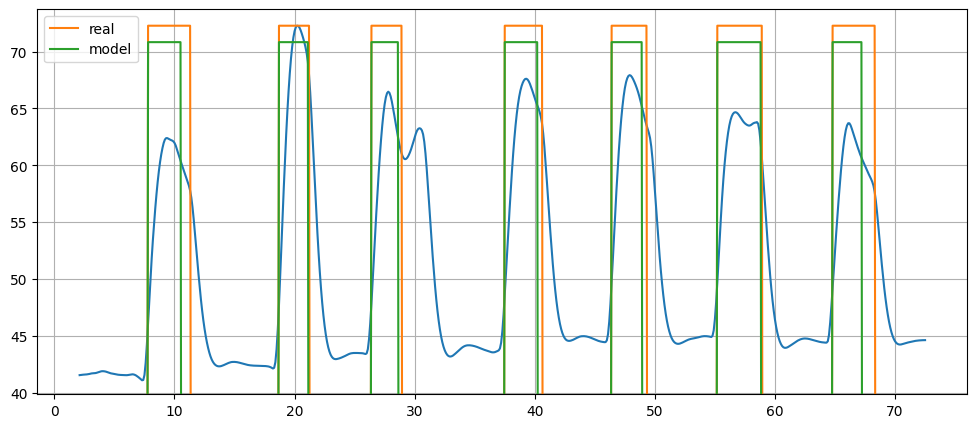

files\test_7.csv


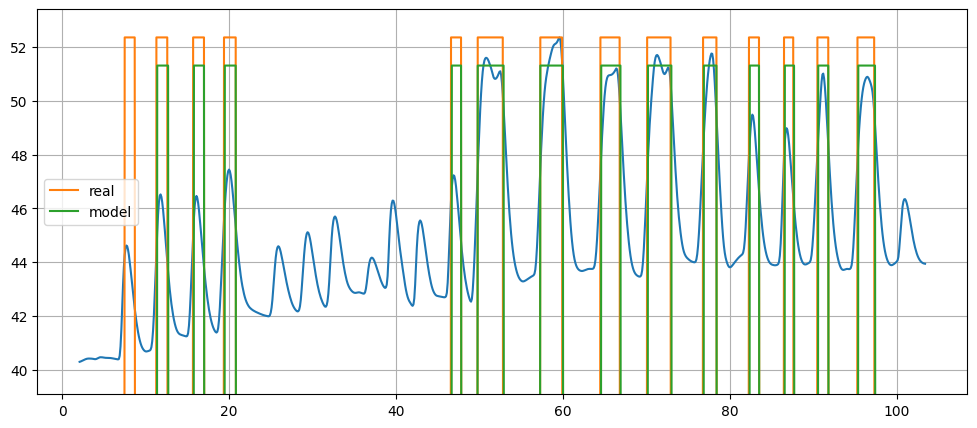

files\test_8.csv


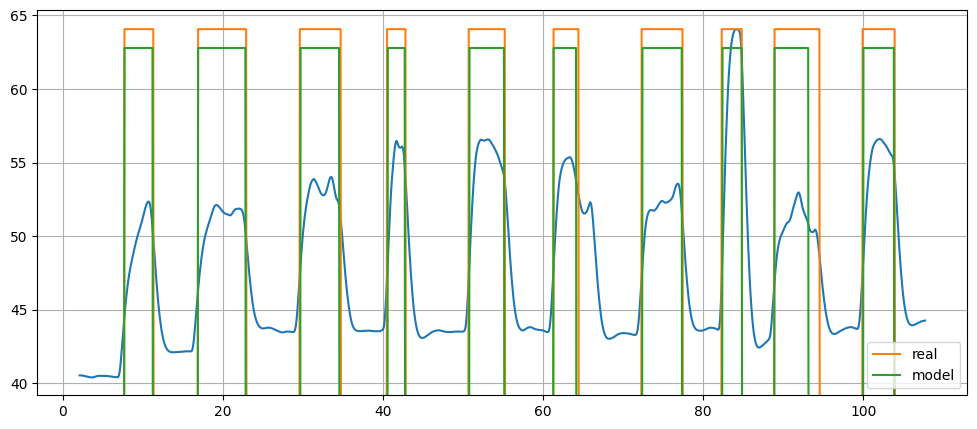

files\test_9.csv


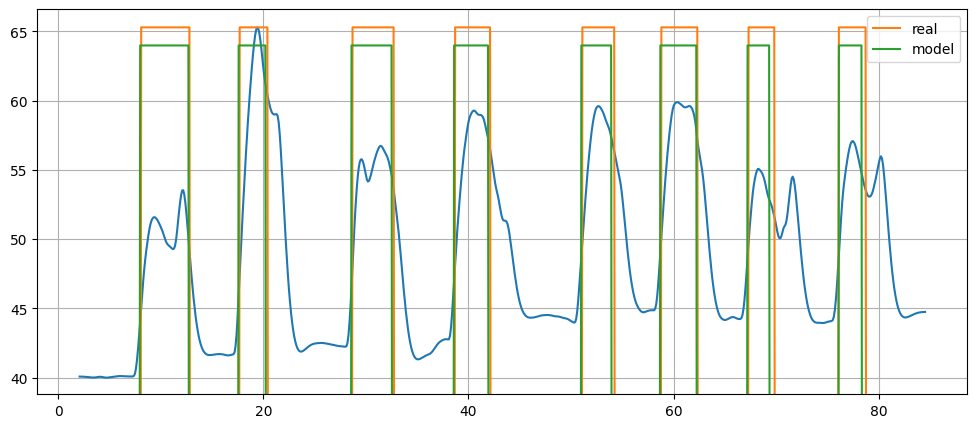

In [19]:
for filePath in files:
    df = pd.read_csv(filePath)
    print(filePath)
    is_blowing = False
    df['arduino'] = df.apply(lambda row: isBlowing(row['mean'], row['ratio']), axis=1)
    plt.figure(figsize=(12, 5))
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.arduino * 0.98 * max(df.pressure), label='model')
    plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
    plt.legend(), plt.grid(), plt.show()